# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

## 1. Data Preprocessing

### For Google Colab only:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

     |████████████████████████████████| 1.1 MB 7.3 MB/s 


## 2. Deep Learning

In [19]:
# for Tensorflow:

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.version.VERSION

'2.7.0'

In [20]:
# Code from Brownlee 2018

# univariate multi-step vector-output stacked lstm example
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

30000
<class 'numpy.ndarray'>
[-0.03374548 -0.00912922  0.01347736 ...  0.02617211  0.03393547
  0.04377749]
float32
(30000,)


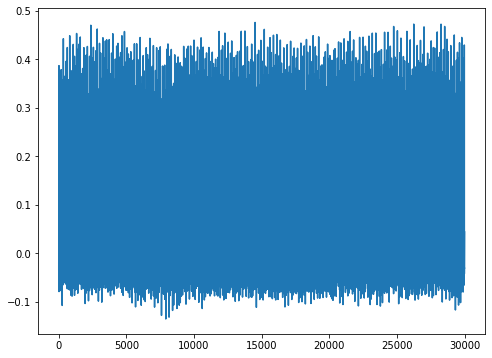

In [21]:

ecg = data[0]
print(len(ecg))
#ecg = ecg[500:5500] # nur mit Untermenge auf Laptop
ecg.ndim
ecg.shape
#plt.plot(ecg)
print(type(ecg))
print(ecg)
print(ecg.dtype)
print(ecg.shape)

plt.plot(ecg)

### Univariate

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        if i % 50 == 0: # to reduce redundancy ## maybe even 100 to *remove* redundancy?
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the sequence
            if out_end_ix > len(sequence):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 3*100, 1*100
# split into samples
X, y = split_sequence(ecg, n_steps_in, n_steps_out)
# summarize the data
print(len(ecg))
print(X.shape,y.shape)

30000
(593, 300) (593, 100)


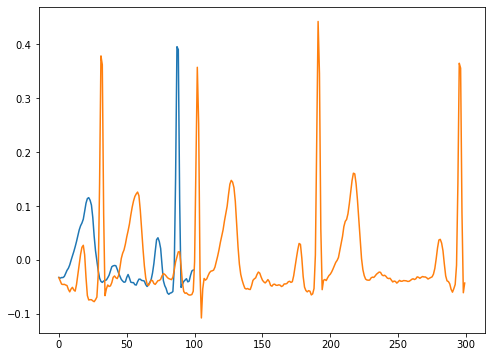

In [ ]:
plt.plot(y[3,:])
plt.plot(X[3,:])
#test2 = nk.signal_smooth(test, method='convolution', kernel='boxzen', size=10, alpha=0.1)
#plt.plot(test2)


In [ ]:
# 3D-Data. X = Input, y = output

# "The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features]"
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
print(X.shape,y.shape)
#plt.plot(y[3,:,0])
print(type(X))
X.dtype

(593, 300, 1) (593, 100, 1)
<class 'numpy.ndarray'>


dtype('float32')

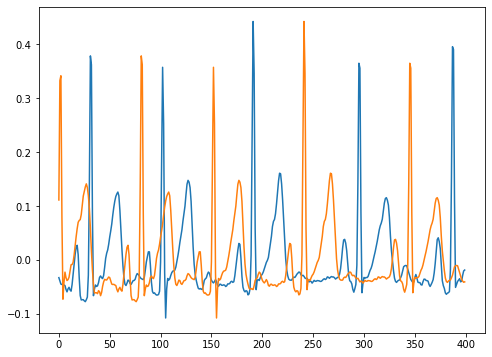

In [ ]:
test = np.append(X[3,:,0], y[3,:,0])
test2 = np.append(X[2,:,0], y[2,:,0])
plt.plot(test)
plt.plot(test2)

In [ ]:
# Data split
print(X.shape,y.shape)

num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_vali =  X[num_train_samples:(num_train_samples+num_val_samples)]
y_vali = y[num_train_samples:(num_train_samples+num_val_samples)]
X_test = X[(num_train_samples+num_val_samples):]
y_test = y[(num_train_samples+num_val_samples):]

print(len(X_train))
print(len(X_vali))
print(len(X_test))

(593, 300, 1) (593, 100, 1)
num_train_samples: 296
num_val_samples: 148
num_test_samples: 149
296
148
149


In [ ]:
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps_in,n_features)))
model.add(LSTM(300, activation='relu'))
#model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=["mae"]) # accuracy does not work

In [ ]:
# fit model
history = model.fit(X_train, y_train, epochs=64, batch_size=32, verbose=1, validation_data=(X_vali, y_vali))

Epoch 1/64


KeyboardInterrupt: 

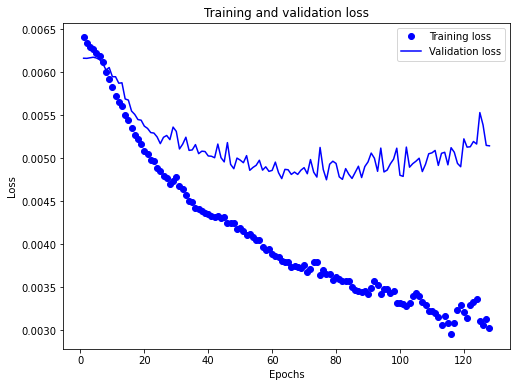

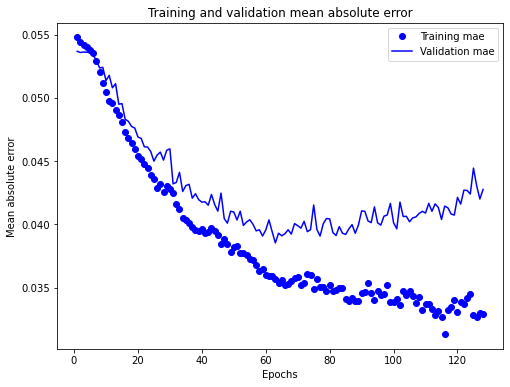

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
mae = history_dict["mae"]
val_mae = history_dict["val_mae"]
plt.plot(epochs, mae, "bo", label="Training mae")
plt.plot(epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

(300, 1)


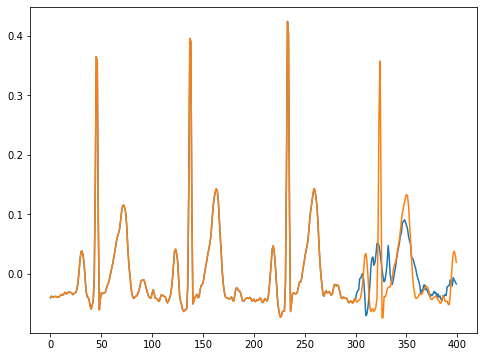

In [ ]:
#print(X_test[1,:,:])
print(X_test[1].shape)

# demonstrate training
yhat = model.predict(X_train,batch_size=10)

trial = 8
test = np.append(X_train[trial],yhat[trial])
test2 = np.append(X_train[trial],y_train[trial])

plt.plot(test)
plt.plot(test2)

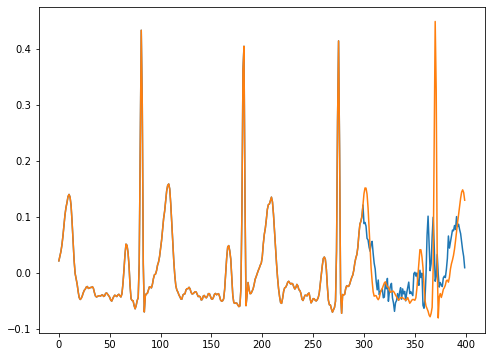

In [ ]:
# demonstrate prediction
yhat = model.predict(X_test,batch_size=10)

trial = 7
test = np.append(X_test[trial],yhat[trial])
test2 = np.append(X_test[trial],y_test[trial])

plt.plot(test)
plt.plot(test2)

In [ ]:
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

### Multivariate

In [ ]:
# Excellent indices:
# 0
# 16
# 20
# 44

In [22]:
data[0].shape

(30000,)

In [23]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        ''' Warning: may overlap between participants when i < Hz (?) + randomization??? '''
        if i % 100 == 0: # to reduce redundancy
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

In [24]:
# define input sequence
in_seq1 = data[0]
in_seq2 = data[16]
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2))
# choose a number of time steps
n_steps_in, n_steps_out = 300, 100
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

(297, 300, 2) (297, 100, 2)


In [25]:
# Data split
print(X.shape,y.shape)

num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_vali =  X[num_train_samples:(num_train_samples+num_val_samples)]
y_vali = y[num_train_samples:(num_train_samples+num_val_samples)]
X_test = X[(num_train_samples+num_val_samples):]
y_test = y[(num_train_samples+num_val_samples):]

print(len(X_train))
print(len(X_vali))
print(len(X_test))

(297, 300, 2) (297, 100, 2)
num_train_samples: 148
num_val_samples: 74
num_test_samples: 75
148
74
75


In [26]:
# define model
model = Sequential()
model.add(LSTM(600, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(600, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

In [27]:
# fit model
history = model.fit(X_train, y_train, epochs=256, batch_size=32, verbose=1, validation_data=(X_vali, y_vali))

Epoch 1/256
5/5 [==============================] - 29s 5s/step - loss: 0.0063 - mae: 0.0517 - val_loss: 0.0064 - val_mae: 0.0527
Epoch 2/256
5/5 [==============================] - 27s 5s/step - loss: 0.0063 - mae: 0.0514 - val_loss: 0.0064 - val_mae: 0.0518
Epoch 3/256
5/5 [==============================] - 27s 5s/step - loss: 0.0063 - mae: 0.0516 - val_loss: 0.0064 - val_mae: 0.0525
Epoch 4/256
5/5 [==============================] - 25s 5s/step - loss: 0.0063 - mae: 0.0516 - val_loss: 0.0064 - val_mae: 0.0519
Epoch 5/256
5/5 [==============================] - 25s 5s/step - loss: 0.0063 - mae: 0.0515 - val_loss: 0.0064 - val_mae: 0.0521
Epoch 6/256
5/5 [==============================] - 26s 5s/step - loss: 0.0063 - mae: 0.0516 - val_loss: 0.0064 - val_mae: 0.0521
Epoch 7/256
5/5 [==============================] - 25s 5s/step - loss: 0.0063 - mae: 0.0515 - val_loss: 0.0064 - val_mae: 0.0522
Epoch 8/256
5/5 [==============================] - 26s 5s/step - loss: 0.0063 - mae: 0.0516 - val

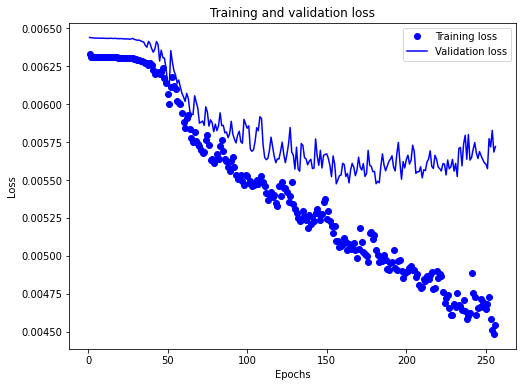

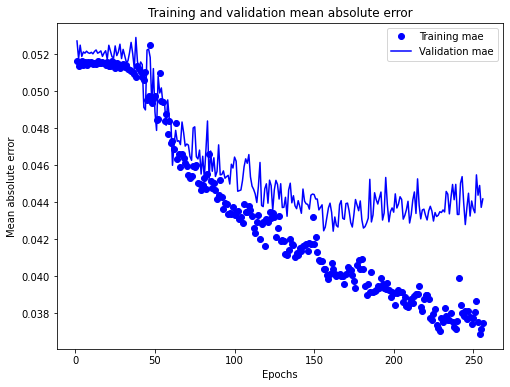

In [28]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
mae = history_dict["mae"]
val_mae = history_dict["val_mae"]
plt.plot(epochs, mae, "bo", label="Training mae")
plt.plot(epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

(300, 2)


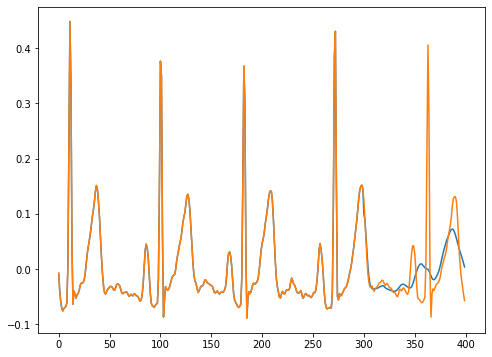

In [29]:
#print(X_test[1,:,:])
print(X_test[1].shape)

# demonstrate training
yhat = model.predict(X_train,batch_size=10)

trial = 8
test = np.append(X_train[trial,:,0],yhat[trial,:,0])
test2 = np.append(X_train[trial,:,0],y_train[trial,:,0])

plt.plot(test)
plt.plot(test2)

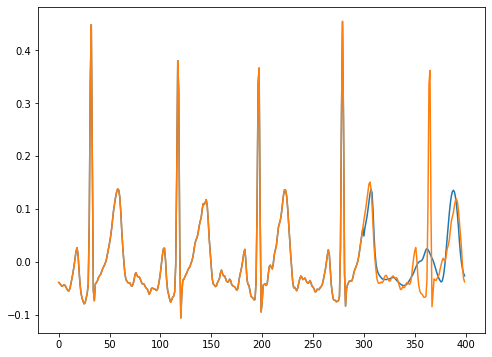

In [31]:
# demonstrate prediction
yhat = model.predict(X_test,batch_size=10)

trial = 7
person = 0
test = np.append(X_test[trial,:,person],yhat[trial,:,person])
test2 = np.append(X_test[trial,:,person],y_test[trial,:,person])

plt.plot(test)
plt.plot(test2)

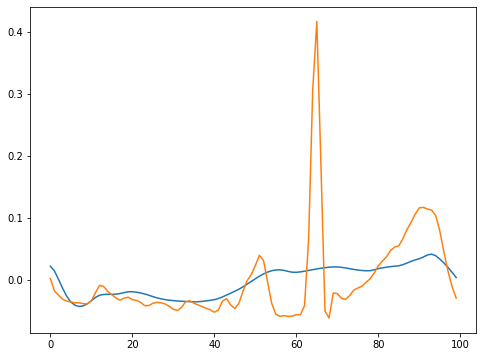

In [32]:

yhat.shape
plt.plot(yhat[2,:,0])
plt.plot(y_test[2,:,0])